# Dataset

In [55]:
import os
import numpy as np
import pandas as pd

from skimage import transform
# import librosa

import torch
from torch.utils.data import Dataset, WeightedRandomSampler

# # local functions
# from dataset.utils import *

In [64]:
class DepressionDataset(Dataset):
    '''create a training, develop, or test dataset
       and load the participant features if it's called 
    '''
    def __init__(self,
                 root_dir,
                 mode,
                 transform=None):
        super(DepressionDataset, self).__init__()
        
        # only train, develop, test dataset allow
        assert mode in ["train", "validation", "test"], \
            "Argument --mode could only be ['train', 'validation', 'test']"

        self.mode = mode
        self.root_dir = root_dir
        self.transform = transform
        self.train_data_path = os.path.join(self.root_dir, 'train_split_Depression_AVEC2017.csv')
        self.valid_data_path = os.path.join(self.root_dir, 'dev_split_Depression_AVEC2017.csv')
        self.test_data_path = os.path.join(self.root_dir, 'full_test_split.csv')
        # load sent2vec model for converting text file to 2D array
#         self.sent2vec = SentenceTransformer('all-mpnet-base-v2')  # output dimension 768

        # load training data # 107 sessions
        if self.mode == "train":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.train_data_path))
            # store ground truth
            ####################################################################################################
            # self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.patientIDs = np.array([303, 321, 362, 363, 426])  # for debugging on my laptop
            ####################################################################################################
            self.phq_binay_gt = np.array([0,1,1,0,1]) # self.data_df['PHQ8_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ8_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
            self.phq_subscores_gt = self.data_df.iloc[:, 4:].to_numpy()

        # load development data # 35 sessions
        if self.mode == "validation":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.valid_data_path))
            # store ground truth
            self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.phq_binay_gt = self.data_df['PHQ8_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ8_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
            self.phq_subscores_gt = self.data_df.iloc[:, 4:].to_numpy()

        # load test data # 47 sessions
        if self.mode == "test":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.test_data_path))
            # store ground truth
            self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.phq_binay_gt = self.data_df['PHQ_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
            # subscores in test data are not provided, thus we initialize it with 0 to avoid error for DataLoader
            self.phq_subscores_gt = np.zeros((self.patientIDs.shape[0],  8))
        
        # get sampler
        target = self.phq_binay_gt  # np.array([0,1,1,0,1])  # self.phq_binay_gt
        class_sample_count = np.unique(target, return_counts=True)[1]
        weight = 1. / class_sample_count
        samples_weight = weight[target]
        samples_weight = torch.from_numpy(samples_weight).double()
        self.sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    
    
    def pre_check(self, data):
        '''
        Basic cleaning process to make sure no missing value
        and that the sum of each PHQ subscore equals to PHQ score 
        Argument:
            data: numpy array
        Return:
            data: numpy array with type "int"
        '''
        # make sure no NaN, Inf, -Inf
        if data.isin([np.nan, np.inf, -np.inf]).any(1).sum():
            print('Replacing NaN, Inf, or -Inf ...')
            data = data.replace([np.inf, -np.inf, np.nan], 0).astype('int')
        else: 
            data = data.astype('int')
            
        # compare the sum of each PHQ subscore to PHQ score
        unequal = data.iloc[:, 4:].sum(axis=1) != data.iloc[:,2]
        if unequal.any() and self.mode != 'test':
            lines = np.where(unequal)
            raise ValueError(("The sum of each PHQ subscore at line {} "
                              "is unequal to the PHQ score").format(lines[0]))
        
        return data
    
    
    def __len__(self):
        return len(self.patientIDs)
    
    
    def __iter__(self):
        return iter(self.patientIDs)
    
    
    def __getitem__(self, idx):
        '''
        Essentional function for creating dataset in PyTorch, which will automatically be
        called in Dataloader and load all the extracted features of the patient in the Batch
        based on the index of self.patientIDs
        Argument:
            idx: int, index of the patient ID in self.patientIDs
        Return:
            session: dict, contains all the extracted features and ground truth of a patient/session 
        '''
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # get the patient session path
        session_num = self.patientIDs[idx]
        session_path = os.path.join(self.root_dir, '{}_P'.format(session_num))
        
        # TODO: if other feature is needed, add more in the following part...
        
        # get key points and gaze direction path
        facial_landmarks_path = os.path.join(session_path, '{}_CLNF_features3D.txt'.format(session_num))
        gaze_direction_path = os.path.join(session_path, '{}_CLNF_gaze.txt'.format(session_num))
        
        # facial feature
        facial_landmarks = self.load_facial_landmarks(facial_landmarks_path)
        # gaze direction feature
        gaze_direction = pd.read_csv(gaze_direction_path).iloc[:, 4:].to_numpy()
        
        # summary
        session = {'patientID': session_num,
                   'session_path': session_path,
                   'facial_landmarks': facial_landmarks,
                   'gaze_direction': gaze_direction,
                   'phq_score_gt': self.phq_score_gt[idx],
                   'phq_binay_gt': self.phq_binay_gt[idx],
                   'phq_subscores_gt': self.phq_subscores_gt[idx],
                   'gender_gt': self.gender_gt[idx]}
        
#         # get all features path of the session
#         facial_landmarks_path = os.path.join(session_path, '{}_CLNF_features3D.txt'.format(session_num))
#         gaze_direction_path = os.path.join(session_path, '{}_CLNF_gaze.txt'.format(session_num))
#         audio_path = os.path.join(session_path, '{}_AUDIO.wav'.format(session_num))
#         text_path = os.path.join(session_path, '{}_TRANSCRIPT.csv'.format(session_num))
        
#         # facial feature
#         facial_landmarks = self.load_facial_landmarks(facial_landmarks_path)
#         # gaze direction feature
#         gaze_direction = pd.read_csv(gaze_direction_path).iloc[:, 4:].to_numpy()
#         # audion feature, but constrain the rows based to match the shape of landmarks/gaze_sample
#         audio, self.audio_parameters = self.load_audio(audio_path)
#         audio = audio[:facial_landmarks.shape[0]]
#         # text feature
#         self.text_feature = self.load_sent2vec(text_path, speaker='Participant')
#         sentence_embedding = self.text_feature['sentence_embeddings']

#         # summary
#         session = {'patientID': session_num,
#                    'session_path': session_path,
#                    'facial_landmarks': facial_landmarks,
#                    'gaze_direction': gaze_direction, 
#                    'audio': audio,
#                    'sentence_embeddings': sentence_embedding,
#                    'phq_score_gt': self.phq_score_gt[idx],
#                    'phq_binay_gt': self.phq_binay_gt[idx],
#                    'phq_subscores_gt': self.phq_subscores_gt[idx],
#                    'gender_gt': self.gender_gt[idx]}
        
        if self.transform:
            session = self.transform(session)
        
        return session
    
    
    def load_facial_landmarks(self, facial_landmarks_path, preprocess=True):
        ''' 
        load the facial landmarks and separately recale 
        each x, y, z coordiante of each frame
        Arguments:
            facial_landmarks_path: string, absolute path to 3D facial landmarks file
            preprocess: boolean, whether normalize the data
        Return:
            landmarks: 2D numpy.ndarray, coordinate (x,y,z) of 68 3D facial points
        '''
        # load the landmarks file
        landmarks = pd.read_csv(facial_landmarks_path).iloc[:, 4:].to_numpy()
        
        if preprocess:
            # recale x, y, z
            landmarks_x = minmax_scaler(landmarks[:, 0:68])
            landmarks_y = minmax_scaler(landmarks[:, 68:136])
            landmarks_z = minmax_scaler(landmarks[:, 136:204])
            # concatenate together
            landmarks = np.concatenate([landmarks_x, landmarks_y, landmarks_z], axis=1)
        
        return landmarks
    

class Padding(object):
    ''' pad zero to each feature matrix so that they all have the same size '''

    def __init__(self,
                 landmarks_output_size=(58989, 204), 
                 gaze_output_size=(58989, 12)):
        super(Padding, self).__init__()
        '''
        Each output size could be 'int' or 'tuple'. 
        Integer would be the number of desired rows
        and Tuple would be the desired 2D array size.

        Here is recommended to keep the number of columns 
        as they are and only set the number of rows with int

        To find the maximum length of rows, please use the 
        'find_max_length' function in utils to search through. 

        The value 386 are the maximum length in our case.
        '''
        assert isinstance(landmarks_output_size, (int, tuple))
        assert isinstance(gaze_output_size, (int, tuple))
        
        self.landmarks_output_size = landmarks_output_size
        self.gaze_output_size = gaze_output_size

        
    def __call__(self, session):
        facial_landmarks = session['facial_landmarks']
        gaze_direction = session['gaze_direction']
        
        # facial landmarks padding along heigh dimension (dim-0)
        if isinstance(self.landmarks_output_size, int):
            h, w = facial_landmarks.shape
            new_h = self.landmarks_output_size if h > self.landmarks_output_size else h
            padded_landmarks = np.zeros((self.landmarks_output_size, w))
            padded_landmarks[:new_h, :w] = facial_landmarks[:new_h, :w]
        # facial landmarks padding along both heigh and width dimension
        else:
            h, w = facial_landmarks.shape
            new_h = self.landmarks_output_size[0] if h > self.landmarks_output_size[0] else h
            new_w = self.landmarks_output_size[1] if w > self.landmarks_output_size[1] else w
            padded_landmarks = np.zeros(self.landmarks_output_size)
            padded_landmarks[:new_h, :new_w] = facial_landmarks[:new_h, :new_w]
            
        # gaze direction padding along heigh dimension (dim-0)
        if isinstance(self.gaze_output_size, int):
            h, w = gaze_direction.shape
            new_h = self.gaze_output_size if h > self.gaze_output_size else h
            padded_gaze = np.zeros((self.gaze_output_size, w))
            padded_gaze[:new_h, :w] = gaze_direction[:new_h, :w]
        # gaze direction padding along both heigh and width dimension
        else:
            h, w = gaze_direction.shape
            new_h = self.gaze_output_size[0] if h > self.gaze_output_size[0] else h
            new_w = self.gaze_output_size[1] if w > self.gaze_output_size[1] else w
            padded_gaze = np.zeros(self.gaze_output_size)
            padded_gaze[:new_h, :new_w] = gaze_direction[:new_h, :new_w]

        # summary
        padded_session = {'patientID': session['patientID'],
                          'session_path': session['session_path'],
                          'facial_landmarks': padded_landmarks,
                          'gaze_direction': padded_gaze, 
                          'phq_score_gt': session['phq_score_gt'],
                          'phq_binay_gt': session['phq_binay_gt'],
                          'phq_subscores_gt': session['phq_subscores_gt'],
                          'gender_gt': session['gender_gt']}

        return padded_session

    
# class Rescale(object):
#     """Rescale the image in a sample to a given size.
#     Arguments:
#         output_size:(tuple or int),  Desired output size. If tuple, output is
#             matched to output_size. If int, smaller of image edges is matched
#             to output_size keeping aspect ratio the same.
#     """

#     def __init__(self, output_size=(256, 256)):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size

#     def __call__(self, session):
#         audio = session['audio']

#         h, w = audio.shape[:2]

#         if isinstance(self.output_size, int):
#             if h > w:
#                 new_h, new_w = self.output_size * h / w, self.output_size
#             else:
#                 new_h, new_w = self.output_size, self.output_size * w / h
#         else:
#             new_h, new_w = self.output_size

#         new_h, new_w = int(new_h), int(new_w)

#         rescaled_audio = transform.resize(audio, (new_h, new_w))

#         # summary
#         rescaled_session = {'patientID': session['patientID'],
#                             'session_path': session['session_path'],
#                             'audio': rescaled_audio,
#                             'phq_score_gt': session['phq_score_gt'],
#                             'phq_binay_gt': session['phq_binay_gt'],
#                             'phq_subscores_gt': session['phq_subscores_gt'],
#                             'gender_gt': session['gender_gt']}

#         return rescaled_session


# class RandomCrop(object):
#     """Crop randomly the image in a sample.
#     Arguments:
#         output_size:(tuple or int), Desired output size. If int, square crop
#             is made.
#     """

#     def __init__(self, output_size=(224, 224)):
#         assert isinstance(output_size, (int, tuple))

#         if isinstance(output_size, int):
#             self.output_size = (output_size, output_size)
#         else:
#             assert len(output_size) == 2
#             self.output_size = output_size

#     def __call__(self, session):
#         audio = session['audio']

#         h, w = audio.shape[:2]
#         new_h, new_w = self.output_size

#         top = np.random.randint(0, h - new_h)
#         left = np.random.randint(0, w - new_w)

#         cropped_audio = audio[top:top + new_h, left:left + new_w]

#         # summary
#         cropped_session = {'patientID': session['patientID'],
#                            'session_path': session['session_path'],
#                            'audio': cropped_audio,
#                            'phq_score_gt': session['phq_score_gt'],
#                            'phq_binay_gt': session['phq_binay_gt'],
#                            'phq_subscores_gt': session['phq_subscores_gt'],
#                            'gender_gt': session['gender_gt']}

#         return cropped_session


class ToTensor(object):
    """Convert ndarrays in sample to Tensors or np.int to torch.tensor."""

    def __call__(self, session):
        
        facial_landmarks = session['facial_landmarks']
        gaze_direction = session['gaze_direction']
        
        converted_session = {'patientID': session['patientID'],
                             'session_path': session['session_path'],
                             'facial_landmarks': torch.from_numpy(session['facial_landmarks']).type(torch.FloatTensor),
                             'gaze_direction': torch.from_numpy(session['gaze_direction']).type(torch.FloatTensor),
                             'phq_score_gt': torch.tensor(session['phq_score_gt']).type(torch.FloatTensor),
                             'phq_binay_gt': torch.tensor(session['phq_binay_gt']).type(torch.FloatTensor),
                             'phq_subscores_gt': torch.from_numpy(session['phq_subscores_gt']).type(torch.FloatTensor),
                             'gender_gt': torch.tensor(session['gender_gt']).type(torch.FloatTensor)}

        return converted_session

## dataset/utils

In [57]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io, transform
from mpl_toolkits.mplot3d import Axes3D


In [58]:
def minmax_scaler(data):
    '''recale the data, which is a 2D matrix, to 0-1 at each row'''
    return (data - data.min(axis=1)[:, np.newaxis]) / (data.max(axis=1) - data.min(axis=1))[:, np.newaxis]


def audio_minmax_scaler(data):
    '''recale audio data based on chosen min max value.
    There will have 'NaN' problem if we rescale the audio data based on each line as 'minmax_scaler' above
    does since some certain lines contain only same value such as -60 dB, which means almost silence. Thus
    we create a new 'audio_minmax_scaler' function to rescale the data.

    Most of the data is range between -60 ~ 20.
    '''
    data_min = -60
    data_max = 20
    return (data - data_min) / (data_max - data_min)


def cosine_similarity(u, v):
    '''Calculate the similarity between 1D arrays'''
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))


def similarity_matrix(array):
    '''Calculate the similarity matrix by given a 2D array'''
    shape = array.shape
    similarity = np.zeros((shape[0], shape[0]))

    for i in range(shape[0]):
        for k in range(shape[0]):
            similarity[i][k] = cosine_similarity(array[i], array[k])

    return similarity


def load_text_file(text_path, speaker='Participant'):
    '''load transcript file and extract the text of the given speaker'''

    def tokenize_corpus(corpus):
        '''tokenzie a given list of string into list of words'''
        tokens = [x.split() for x in corpus]
        return tokens

    # only 'Ellie', 'Participant', 'both' are allow
    assert speaker in ['Ellie', 'Participant', 'both'], \
        "Argument --speaker could only be ['Ellie', 'Participant', 'both']"

    text_file = pd.read_csv(text_path)
    # tokenize the text file, filter out all \t space and unnecessary columns such as time, participent
    tokenized_words = tokenize_corpus(text_file.values.tolist()[i][0] for i in range(text_file.shape[0]))

    sentences = []
    sentences_idx = []

    if speaker == 'Ellie':
        for idx, sentence in enumerate(tokenized_words):
            if sentence[2] == 'Ellie':
                sentences.append(sentence[3:])
                sentences_idx.append(idx)
    elif speaker == 'Participant':
        for idx, sentence in enumerate(tokenized_words):
            if sentence[2] == 'Participant':
                sentences.append(sentence[3:])
                sentences_idx.append(idx)

    else:  # speaker == 'both'
        sentences = [tokenized_words[i][3:] for i in range(len(tokenized_words))]
        sentences_idx = list(range(len(tokenized_words)))

    # recombine 2D list of words into 1D list of sentence
    final_sentences = [" ".join(sentences[i]).lower() for i in range(len(sentences))]

    return final_sentences


def find_max_length(root_dir):
    '''find out the maximum lenghth of each features among all patients'''

    # initialize each value
    max_length = {'landmarks': 0,
                  'gaze_samples': 0,
                  'sentences': 0}

    for name in os.listdir(root_dir):
        name_path = os.path.join(root_dir, name)
        if os.path.isdir(name_path) and name.endswith('_P'):
            session = name.split('_')[0]
            print('searching through patient {} ...'.format(session))

            facial_landmarks_path = os.path.join(name_path, '{}_CLNF_features3D.txt'.format(session))
            gaze_direction_path = os.path.join(name_path, '{}_CLNF_gaze.txt'.format(session))
            text_path = os.path.join(name_path, '{}_TRANSCRIPT.csv'.format(session))

            facial_landmarks = pd.read_csv(facial_landmarks_path)
            if len(facial_landmarks) > max_length['landmarks']:
                max_length['landmarks'] = len(facial_landmarks)

            gaze_direction = pd.read_csv(gaze_direction_path)
            if len(gaze_direction) > max_length['gaze_samples']:
                max_length['gaze_samples'] = len(gaze_direction)

            sentences = load_text_file(text_path, speaker='Participant')
            if len(sentences) > max_length['sentences']:
                max_length['sentences'] = len(sentences)

    if max_length['gaze_samples'] != max_length['landmarks']:
        max_length['gaze_samples'] = max_length['landmarks']

    return max_length


########################################################################################################################
# plot or diagram related
########################################################################################################################

def show_landmarks_gaze(landmarks, gaze_direction, frame=30, gaze_factor=0.3):
        """Show image with landmarks for a batch of samples.
        Arguments:
            landmarks_gaze: dict, could be one or more sessions, should
                            contain 'facial_landmarks' & 'gaze_direction' array
            frame: int, index of the desired frame to show
            gaze_factor: float, length of the gaze vector
        Return:
            plot the image with 68 landmarks + gaze direction
            of both eyes for visualization
        """

        # get x, y, z coordinate of landmarks of a frame
        x_3D = landmarks[frame, 0: 68]
        y_3D = landmarks[frame, 68: 136]
        z_3D = landmarks[frame, 136: 204]

        # get gaze direction vector of a frame
        gx_l, gy_l, gz_l, gx_r, gy_r, gz_r = gaze_direction[frame, :6]
        gxh_l, gyh_l, gzh_l, gxh_r, gyh_r, gzh_r = gaze_direction[frame, 6:]

        # calculate the middle point of each eye
        left_eye_x = (x_3D[37] + x_3D[38] + x_3D[40] + x_3D[41])/4
        left_eye_y = (y_3D[37] + y_3D[38] + y_3D[40] + y_3D[41])/4
        left_eye_z = (z_3D[37] + z_3D[38] + z_3D[40] + z_3D[41])/4
        right_eye_x = (x_3D[43] + x_3D[44] + x_3D[46] + x_3D[47])/4
        right_eye_y = (y_3D[43] + y_3D[44] + y_3D[46] + y_3D[47])/4
        right_eye_z = (z_3D[43] + z_3D[44] + z_3D[46] + z_3D[47])/4

        # plot figure
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x_3D,y_3D,z_3D)
        # plot gaze direction in world coordinate
        ax.plot([left_eye_x, left_eye_x+gx_l*gaze_factor], 
                [left_eye_y, left_eye_y+gy_l*gaze_factor], 
                [left_eye_z, left_eye_z+gz_l*gaze_factor], 
                'r-', label='Gaze direction in world coordinate')
        ax.plot([right_eye_x, right_eye_x+gx_r*gaze_factor], 
                [right_eye_y, right_eye_y+gy_r*gaze_factor], 
                [right_eye_z, right_eye_z+gz_r*gaze_factor], 
                'r-')
        # plot gaze direction in head coordinate
        ax.plot([left_eye_x, left_eye_x+gxh_l*gaze_factor], 
                [left_eye_y, left_eye_y+gyh_l*gaze_factor], 
                [left_eye_z, left_eye_z+gzh_l*gaze_factor], 
                'g-', label='Gaze direction in head coordinate')
        ax.plot([right_eye_x, right_eye_x+gxh_r*gaze_factor], 
                [right_eye_y, right_eye_y+gyh_r*gaze_factor], 
                [right_eye_z, right_eye_z+gzh_r*gaze_factor], 
                'g-')
        # plot set up
        ax.view_init(elev = -80, azim = -90)
        ax.set_title('68 3D Facial Keypoints of Patient')
        ax.legend(loc = 'lower center')
        ax.set_xlabel("x coordinate") 
        ax.set_ylabel("y coordinate")
        ax.set_zlabel("z coordinate")
        plt.tight_layout()
        plt.show()
        
        
def show_spectrogram(audio_feature, audio_parameters, y_axis="log"):
    """Show log-spectrogram for a batch of samples.
    Arguments:
        audio_feature: 2D numpy.ndarray, extracted audio feature (spectra) in dB
        audio_parameters: dict, all parameters setting of STFT
                          we used for feature extraction
        y_axis: certain string, scale of the y axis. could be 'linear' or 'log'
    Return:
        plot the spectrogram
    """

    # transpose, so the column corresponds to time series
    audio_feature = np.transpose(audio_feature)

    plt.figure(figsize=(25, 10))
    im = librosa.display.specshow(audio_feature,
                                  sr=audio_parameters['sample_rate'],
                                  hop_length=audio_parameters['hop_size'],
                                  x_axis="time",
                                  y_axis=y_axis)
    plt.colorbar(format="%+2.f dB")
    return im


def show_mel_filter_banks(filter_banks, audio_parameters):
    """Show Mel filter bank for a batch of samples.
    Arguments:
        filter_banks: 2D numpy.ndarray, please use self.filter_banks to get the value,
                      but make sure load_audio(spectro_type='mel_spectrogram') is called
        audio_parameters: dict, all parameters setting of STFT
                                we used for feature extraction
    Return:
        visualize the mel filter banks
    """
    plt.figure(figsize=(25, 10))
    im = librosa.display.specshow(filter_banks,
                                  sr=audio_parameters['sample_rate'],
                                  x_axis="linear")
    plt.colorbar(format="%+2.f")
    return im


def show_text_correlation(text_feature, start_sent, sent_len):
    """Show the correlation between each sentence.
    Arguments:
        text_feature: dict, one attribute of DepressionDataset, which
                      includes converted sentence embedding vectors (2D numpy.ndarray)
        start_sent: int, start index of the sentence you want
        sent_len: int, number of sentence you want to compare
                  (size of correlation matrix)
    Return:
        plot the correlation matrix between sentences
    """
    # calculate correlation matrix
    correlation = np.corrcoef(text_feature['sentence_embeddings'][int(start_sent):int(start_sent + sent_len)])
    plt.figure(figsize=(12, 12))
    # plot heatmap
    heatmap = sns.heatmap(correlation, annot=True, fmt='.2g')  # cbar_kws={'label': 'correlation'}
    # set scale label
    heatmap.set_xticklabels(text_feature['indices'][int(start_sent):int(start_sent + sent_len)])  # rotation=-30
    heatmap.set_yticklabels(text_feature['indices'][int(start_sent):int(start_sent + sent_len)], rotation=0)
    # set label
    plt.xlabel("sentence number in conversation")
    plt.ylabel("sentence number in conversation")
    plt.show()


def show_similarity_matrix(text_feature, start_sent, sent_len):
    '''plot the result of similarity matrix as heatmap'''
    # calculate similarity
    similarity = similarity_matrix(text_feature['sentence_embeddings'][int(start_sent):int(start_sent + sent_len)])
    # plot heatmap
    plt.figure(figsize=(16, 16))
    heatmap = sns.heatmap(similarity, annot=True, fmt='.2g')  # cbar_kws={'label': 'correlation'}
    # set scale label
    heatmap.set_xticklabels(text_feature['indices'][int(start_sent):int(start_sent + sent_len)])  # rotation=-30
    heatmap.set_yticklabels(text_feature['indices'][int(start_sent):int(start_sent + sent_len)], rotation=0)
    # set label
    plt.xlabel("sentence number in conversation")
    plt.ylabel("sentence number in conversation")
    plt.show()

In [68]:
###############
# test the code
###############

if __name__ == '__main__':
    import sys
    from torch.utils.data import DataLoader
    from torchvision import transforms

    # sys.path.append('C:/Users/denni/Documents/KIT Studium/Bachelorarbeit')
    root_dir = 'C:/Users/denni/Documents/KIT Studium/Bachelorarbeit'

    # test 3: try to load the dataset with DataLoader
    transformed_dataset = DepressionDataset(os.path.join(root_dir, 'DAIC-WOZ Dataset'), 'train', 
                                            transform=transforms.Compose([Padding(), ToTensor()]))

    # create dataloader
    dataloader = DataLoader(transformed_dataset,
                            batch_size=2,
                            shuffle=False,
                            num_workers=0,
                            sampler=transformed_dataset.sampler)
    
    # iterate through batches
    for i_batch, sample_batched in enumerate(dataloader):
        print('Batch number: ', i_batch, ', facial_landmarks: ', sample_batched['facial_landmarks'].size())
        print('Batch number: ', i_batch, ', gaze_direction: ', sample_batched['gaze_direction'].size())
        print("Batch number {}, 0/1: {}/{}".format(i_batch,
                                          len(np.where(sample_batched['phq_binay_gt'].numpy() == 0)[0]),
                                          len(np.where(sample_batched['phq_binay_gt'].numpy() == 1)[0])))
        print('=================================')
        if i_batch == 1:
            test_batch_2 = sample_batched
        if i_batch == 2:
            test_batch_1 = sample_batched
            

Batch number:  0 , facial_landmarks:  torch.Size([2, 58989, 204])
Batch number:  0 , gaze_direction:  torch.Size([2, 58989, 12])
Batch number 0, 0/1: 1/1
Batch number:  1 , facial_landmarks:  torch.Size([2, 58989, 204])
Batch number:  1 , gaze_direction:  torch.Size([2, 58989, 12])
Batch number 1, 0/1: 1/1
Batch number:  2 , facial_landmarks:  torch.Size([1, 58989, 204])
Batch number:  2 , gaze_direction:  torch.Size([1, 58989, 12])
Batch number 2, 0/1: 1/0


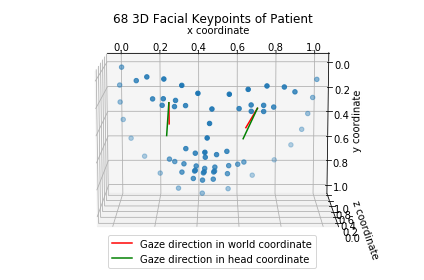

In [7]:
show_landmarks_gaze(landmarks=test_batch_1['facial_landmarks'][0], 
                    gaze_direction=test_batch_1['gaze_direction'][0], 
                    frame=30)

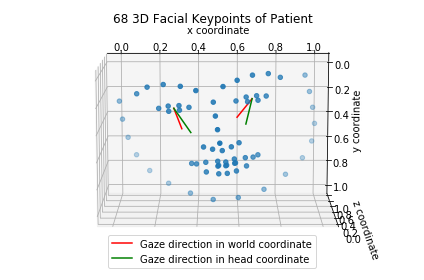

In [8]:
show_landmarks_gaze(landmarks=test_batch_2['facial_landmarks'][1],    # batch 1
                    gaze_direction=test_batch_2['gaze_direction'][1], # batch 1
                    frame=30)

# Debug ST-GCN

**TODO :**
- ~~create graph => edge connection (self & neighbor) + center~~


- ST-GCN config file part
  - add 'ST-GCN config' & subsectoin 'Graph config'
  
  
- STGCN
  - IN-CHANNELS: in_channels
  - N_Class:
  - GRAPH:
    - LAYOUT:
    - STRATEGY:

In [9]:
from gcn.st_gcn import ST_GCN

In [10]:
test_config = {'STGCN':
               {'IN-CHANNELS': 3, 'N_Class': 4, 'GRAPH':
                {'layout': 'openface', 'strategy': 'spatial'}}}

###  - Debug graph

In [11]:
import numpy as np


class Graph():
    """ The Graph to model the skeletons extracted by the openpose

    Args:
        strategy (string): must be one of the follow candidates
        - uniform: Uniform Labeling
        - distance: Distance Partitioning
        - spatial: Spatial Configuration
        For more information, please refer to the section 'Partition Strategies'
            in our paper (https://arxiv.org/abs/1801.07455).

        layout (string): must be one of the follow candidates
        - openpose: Is consists of 18 joints. For more information, please
            refer to https://github.com/CMU-Perceptual-Computing-Lab/openpose#output
        - ntu-rgb+d: Is consists of 25 joints. For more information, please
            refer to https://github.com/shahroudy/NTURGB-D

        max_hop (int): the maximal distance between two connected nodes
        dilation (int): controls the spacing between the kernel points

    """
    def __init__(self,
                 layout='openpose',
                 strategy='uniform',
                 max_hop=1,
                 dilation=1):
        self.max_hop = max_hop
        self.dilation = dilation

        self.get_edge(layout)
        self.hop_dis = get_hop_distance(self.num_node,
                                        self.edge,
                                        max_hop=max_hop)
        self.get_adjacency(strategy)

    def __str__(self):
        return self.A

    def get_edge(self, layout):
        # edge is a list of [child, parent] paris

        if layout == 'openface':
            self.num_node = 68
            self_link = [(i, i) for i in range(self.num_node)]
            neighbor_link = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9),
                             (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16),
                             (17, 18), (18, 19), (19, 20), (20, 21), (22, 23), (23, 24), (24, 25), (25, 26), 
                             (27, 28), (28, 29), (29, 30), (30, 33), (31, 32), (32, 33), (33, 34), (34, 35),
                             (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 36), (42, 43), (43, 44), 
                             (44, 45), (45, 46), (46, 47), (47, 42), (48, 49), (49, 50), (50, 51), (51, 52), 
                             (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 48),
                             (60, 61), (61, 62), (62, 63), (63, 64), (64, 65), (65, 66), (66, 67), (67, 60)]
            self.edge = self_link + neighbor_link
            self.center = 31 - 1
            
        elif layout == 'openface+gaze':
            self.num_node = 72
            self_link = [(i, i) for i in range(self.num_node)]
            neighbor_link = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9),
                             (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16),
                             (17, 18), (18, 19), (19, 20), (20, 21), (22, 23), (23, 24), (24, 25), (25, 26), 
                             (27, 28), (28, 29), (29, 30), (30, 33), (31, 32), (32, 33), (33, 34), (34, 35),
                             (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 36), (42, 43), (43, 44), 
                             (44, 45), (45, 46), (46, 47), (47, 42), (48, 49), (49, 50), (50, 51), (51, 52), 
                             (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 48),
                             (60, 61), (61, 62), (62, 63), (63, 64), (64, 65), (65, 66), (66, 67), (67, 60)]
            gaze_link = [(68, 36), (68, 37), (68, 38), (68, 39), (68, 40), (68, 41),
                         (69, 42), (69, 43), (69, 44), (69, 45), (69, 46), (69, 47),
                         (70, 36), (70, 37), (70, 38), (70, 39), (70, 40), (70, 41),
                         (71, 42), (71, 43), (71, 44), (71, 45), (71, 46), (71, 47)]
            self.edge = self_link + neighbor_link + gaze_link
            self.center = 31 - 1
        
        elif layout == 'openpose':
            self.num_node = 18
            self_link = [(i, i) for i in range(self.num_node)]
            neighbor_link = [(4, 3), (3, 2), (7, 6), (6, 5),
                             (13, 12), (12, 11), (10, 9), (9, 8), (11, 5),
                             (8, 2), (5, 1), (2, 1), (0, 1), (15, 0), (14, 0),
                             (17, 15), (16, 14)]
            self.edge = self_link + neighbor_link
            self.center = 1
            
        elif layout == 'ntu-rgb+d':
            self.num_node = 25
            self_link = [(i, i) for i in range(self.num_node)]
            neighbor_1base = [(1, 2), (2, 21), (3, 21),
                              (4, 3), (5, 21), (6, 5), (7, 6), (8, 7), (9, 21),
                              (10, 9), (11, 10), (12, 11), (13, 1), (14, 13),
                              (15, 14), (16, 15), (17, 1), (18, 17), (19, 18),
                              (20, 19), (22, 23), (23, 8), (24, 25), (25, 12)]
            neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_1base]
            self.edge = self_link + neighbor_link
            self.center = 21 - 1
        elif layout == 'ntu_edge':
            self.num_node = 24
            self_link = [(i, i) for i in range(self.num_node)]
            neighbor_1base = [(1, 2), (3, 2), (4, 3), (5, 2), (6, 5), (7, 6),
                              (8, 7), (9, 2), (10, 9), (11, 10), (12, 11),
                              (13, 1), (14, 13), (15, 14), (16, 15), (17, 1),
                              (18, 17), (19, 18), (20, 19), (21, 22), (22, 8),
                              (23, 24), (24, 12)]
            neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_1base]
            self.edge = self_link + neighbor_link
            self.center = 2
        elif layout == 'coco':
            self.num_node = 17
            self_link = [(i, i) for i in range(self.num_node)]
            neighbor_1base = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13],
                              [6, 12], [7, 13], [6, 7], [8, 6], [9, 7],
                              [10, 8], [11, 9], [2, 3], [2, 1], [3, 1], [4, 2],
                              [5, 3], [4, 6], [5, 7]]
            neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_1base]
            self.edge = self_link + neighbor_link
            self.center = 0
        # elif layout=='customer settings'
        #     pass
        else:
            raise ValueError("Do Not Exist This Layout.")

    def get_adjacency(self, strategy):
        valid_hop = range(0, self.max_hop + 1, self.dilation)
        adjacency = np.zeros((self.num_node, self.num_node))
        for hop in valid_hop:
            adjacency[self.hop_dis == hop] = 1
        normalize_adjacency = normalize_digraph(adjacency)

        if strategy == 'uniform':
            A = np.zeros((1, self.num_node, self.num_node))
            A[0] = normalize_adjacency
            self.A = A
        elif strategy == 'distance':
            A = np.zeros((len(valid_hop), self.num_node, self.num_node))
            for i, hop in enumerate(valid_hop):
                A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis ==
                                                                hop]
            self.A = A
        elif strategy == 'spatial':
            A = []
            for hop in valid_hop:
                a_root = np.zeros((self.num_node, self.num_node))
                a_close = np.zeros((self.num_node, self.num_node))
                a_further = np.zeros((self.num_node, self.num_node))
                for i in range(self.num_node):
                    for j in range(self.num_node):
                        if self.hop_dis[j, i] == hop:
                            if self.hop_dis[j, self.center] == self.hop_dis[
                                    i, self.center]:
                                a_root[j, i] = normalize_adjacency[j, i]
                            elif self.hop_dis[j, self.center] > self.hop_dis[
                                    i, self.center]:
                                a_close[j, i] = normalize_adjacency[j, i]
                            else:
                                a_further[j, i] = normalize_adjacency[j, i]
                if hop == 0:
                    A.append(a_root)
                else:
                    A.append(a_root + a_close)
                    A.append(a_further)
            A = np.stack(A)
            self.A = A
        else:
            raise ValueError("Do Not Exist This Strategy")


def get_hop_distance(num_node, edge, max_hop=1):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1

    # compute hop steps
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(max_hop + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(max_hop, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis


def normalize_digraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    AD = np.dot(A, Dn)
    return AD


def normalize_undigraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-0.5)
    DAD = np.dot(np.dot(Dn, A), Dn)
    return DAD

In [12]:
test_graph = Graph(layout='openface+gaze',
                   strategy='spatial')

# important attribute after 'get_edge'
test_graph.center
test_graph.num_node
test_graph.edge

# important attribute after 'get_hop_distance'
test_graph.hop_dis  # shape: num_node x num_node

# output created graph "A" looks like:
print('shape: ', test_graph.A.shape)
test_graph.A[0]


shape:  (3, 72, 72)


array([[0.5       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.14285714, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.14285714,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.14285714]])

#### **kwargs (keyword arguments)

In [13]:
def foo(a, layout, strategy):
    print(a, layout, strategy)

obj = {'b':10, 'c':'lee'}

foo(100, **test_config['STGCN']['GRAPH'])
# 100 10 lee

100 openface spatial


In [14]:
test_config['STGCN']['GRAPH']

{'layout': 'openface', 'strategy': 'spatial'}

### ST-GCN model 

In [1]:
from gcn.st_gcn import ST_GCN

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from gcn.graph import Graph
from gcn.gconv_origin import ConvTemporalGraphical


def zero(x):
    return 0


def iden(x):
    return x


class ST_GCN(nn.Module):
    r"""Spatial temporal graph convolutional networks.

    Args:
        in_channels (int): Number of channels in the input data
        num_class (int): Number of classes for the classification task
        graph_cfg (dict): The arguments for building the graph
        edge_importance_weighting (bool): If ``True``, adds a learnable
            importance weighting to the edges of the graph
        **kwargs (optional): Other parameters for graph convolution units

    Shape:
        - Input: :math:`(N, in_channels, T_{in}, V_{in}, M_{in})`
        - Output: :math:`(N, num_class)` where
            :math:`N` is a batch size,
            :math:`T_{in}` is a length of input sequence,
            :math:`V_{in}` is the number of graph nodes,
            :math:`M_{in}` is the number of instance in a frame.
    """
    def __init__(self,
                 in_channels,
                 num_class,
                 graph_cfg,
                 edge_importance_weighting=True,
                 data_bn=True,
                 **kwargs):
        super().__init__()

        # load graph
        self.graph = Graph(**graph_cfg)
        A = torch.tensor(self.graph.A,
                         dtype=torch.float32,
                         requires_grad=False)
        self.register_buffer('A', A)

        # build networks
        spatial_kernel_size = A.size(0)
        temporal_kernel_size = 9
        kernel_size = (temporal_kernel_size, spatial_kernel_size)
        self.data_bn = nn.BatchNorm1d(in_channels *
                                      A.size(1)) if data_bn else iden
        kwargs0 = {k: v for k, v in kwargs.items() if k != 'dropout'}
        self.st_gcn_networks = nn.ModuleList((
            st_gcn_block(in_channels,
                         64,
                         kernel_size,
                         1,
                         residual=False,
                         **kwargs0),
            st_gcn_block(64, 64, kernel_size, 1, **kwargs),
            st_gcn_block(64, 64, kernel_size, 1, **kwargs),
            st_gcn_block(64, 64, kernel_size, 1, **kwargs),
            st_gcn_block(64, 128, kernel_size, 2, **kwargs),
            st_gcn_block(128, 128, kernel_size, 1, **kwargs),
            st_gcn_block(128, 128, kernel_size, 1, **kwargs),
            st_gcn_block(128, 256, kernel_size, 2, **kwargs),
            st_gcn_block(256, 256, kernel_size, 1, **kwargs),
            st_gcn_block(256, 256, kernel_size, 1, **kwargs),
        ))

        # initialize parameters for edge importance weighting
        if edge_importance_weighting:
            self.edge_importance = nn.ParameterList([
                nn.Parameter(torch.ones(self.A.size()))
                for i in self.st_gcn_networks
            ])
        else:
            self.edge_importance = [1] * len(self.st_gcn_networks)

        # fcn for prediction
        self.fcn = nn.Conv2d(256, num_class, kernel_size=1)

    def forward(self, x):
        # data normalization
        N, C, T, V, M = x.size()
        x = x.permute(0, 4, 3, 1, 2).contiguous()
        x = x.view(N * M, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, M, V, C, T)
        x = x.permute(0, 1, 3, 4, 2).contiguous()
        x = x.view(N * M, C, T, V)

        # forward
        for gcn, importance in zip(self.st_gcn_networks, self.edge_importance):
            x, _ = gcn(x, self.A * importance)

        # global pooling
        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(N, M, -1, 1, 1).mean(dim=1)

        # prediction
        x = self.fcn(x)
        x = x.view(x.size(0), -1)

        return x

    def extract_feature(self, x):

        # data normalization
        N, C, T, V, M = x.size()
        x = x.permute(0, 4, 3, 1, 2).contiguous()
        x = x.view(N * M, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, M, V, C, T)
        x = x.permute(0, 1, 3, 4, 2).contiguous()
        x = x.view(N * M, C, T, V)

        # forwad
        for gcn, importance in zip(self.st_gcn_networks, self.edge_importance):
            x, _ = gcn(x, self.A * importance)

        _, c, t, v = x.size()
        feature = x.view(N, M, c, t, v).permute(0, 2, 3, 4, 1)

        # prediction
        x = self.fcn(x)
        output = x.view(N, M, -1, t, v).permute(0, 2, 3, 4, 1)

        return output, feature


class st_gcn_block(nn.Module):
    r"""Applies a spatial temporal graph convolution over an input graph sequence.

    Args:
        in_channels (int): Number of channels in the input sequence data
        out_channels (int): Number of channels produced by the convolution
        kernel_size (tuple): Size of the temporal convolving kernel and graph convolving kernel
        stride (int, optional): Stride of the temporal convolution. Default: 1
        dropout (int, optional): Dropout rate of the final output. Default: 0
        residual (bool, optional): If ``True``, applies a residual mechanism. Default: ``True``

    Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels, T_{in}, V)` format
        - Input[1]: Input graph adjacency matrix in :math:`(K, V, V)` format
        - Output[0]: Outpu graph sequence in :math:`(N, out_channels, T_{out}, V)` format
        - Output[1]: Graph adjacency matrix for output data in :math:`(K, V, V)` format

        where
            :math:`N` is a batch size,
            :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
            :math:`T_{in}/T_{out}` is a length of input/output sequence,
            :math:`V` is the number of graph nodes.

    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dropout=0,
                 residual=True):
        super().__init__()

        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1
        padding = ((kernel_size[0] - 1) // 2, 0)

        self.gcn = ConvTemporalGraphical(in_channels, out_channels,
                                         kernel_size[1])

        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                (kernel_size[0], 1),
                (stride, 1),
                padding,
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout, inplace=True),
        )

        if not residual:
            self.residual = zero

        elif (in_channels == out_channels) and (stride == 1):
            self.residual = iden

        else:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels,
                          out_channels,
                          kernel_size=1,
                          stride=(stride, 1)),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, A):

        res = self.residual(x)
        x, A = self.gcn(x, A)
        x = self.tcn(x) + res

        return self.relu(x), A

In [95]:
test_config = {'STGCN':
               {'IN-CHANNELS': 3, 'N_Class': 4, 'DROPOUT': 0.2, 'GRAPH':
                {'layout': 'openface', 'strategy': 'spatial'}}}

In [31]:
test_config = {'STGCN':{'IN-CHANNELS': 3, 'N_Class': 4, 'DROPOUT': 0.2, 'GRAPH':{'layout': 'openface', 'strategy': 'spatial'}}}

In [32]:
model = ST_GCN(in_channels=test_config['STGCN']['IN-CHANNELS'],
               num_class=test_config['STGCN']['N_Class'],
               graph_cfg=test_config['STGCN']['GRAPH'],
               edge_importance_weighting=True,
               data_bn=True,
               dropout=test_config['STGCN']['DROPOUT'])

model.__dict__['_modules']

OrderedDict([('data_bn',
              BatchNorm1d(204, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('st_gcn_networks',
              ModuleList(
                (0): st_gcn_block(
                  (gcn): ConvTemporalGraphical(
                    (conv): Conv2d(3, 192, kernel_size=(1, 1), stride=(1, 1))
                  )
                  (tcn): Sequential(
                    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                    (1): ReLU(inplace=True)
                    (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
                    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                    (4): Dropout(p=0, inplace=True)
                  )
                  (relu): ReLU(inplace=True)
                )
                (1): st_gcn_block(
                  (gcn): ConvTemporalGraphical(
                    (conv): Conv2d(64,

In [102]:
test_batch_2['facial_landmarks'].shape

torch.Size([2, 58989, 204])

In [103]:
test_batch_1['facial_landmarks'].shape

torch.Size([1, 58989, 204])

In [104]:
batch_size = 2
keypoints_input = test_batch_2['facial_landmarks'].view(2, -1, 3, 68, 1).permute(0,2,1,3,4).contiguous()
keypoints_input.shape

torch.Size([2, 3, 58989, 68, 1])

In [ ]:
# randomly initialize the input
input = torch.randn(2, 3, 58989, 68, 1, requires_grad=True)

In [16]:
# result = model(keypoints_input)
# result.shape

In [33]:
block_model = st_gcn_block(in_channels=test_config['STGCN']['IN-CHANNELS'],
                           out_channels=64,
                           kernel_size=(9, 3),
                           stride=1,
                           dropout=0,
                           residual=False)

In [40]:
block_input = torch.randn(2, 3, 58989, 68, requires_grad=True)

test_graph = Graph(layout='openface',
                   strategy='spatial')
A = torch.tensor(test_graph.A,
                 dtype=torch.float32,
                 requires_grad=False)

In [1]:
# output, A = block_model(block_input, A*1)

# WeightedRandomSampler

In [49]:
# example

import torch
from torch.utils.data import WeightedRandomSampler

numDataPoints = 1000
data_dim = 5
bs = 100

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),
                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))

print('target train 0/1: {}/{}'.format(
    len(np.where(target == 0)[0]), len(np.where(target == 1)[0])))

# class_sample_count = np.array(
#     [len(np.where(target == t)[0]) for t in np.unique(target)])
class_sample_count = np.unique(target, return_counts=True)[1]

weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in target])
samples_weight = weight[target]

samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

target = torch.from_numpy(target).long()
train_dataset = torch.utils.data.TensorDataset(data, target)

train_loader = DataLoader(
    train_dataset, batch_size=bs, num_workers=1, sampler=sampler)

for i, (data, target) in enumerate(train_loader):
    print("batch index {}, 0/1: {}/{}".format(i,
                                              len(np.where(target.numpy() == 0)[0]),
                                              len(np.where(target.numpy() == 1)[0])))

target train 0/1: 900/100
batch index 0, 0/1: 59/41
batch index 1, 0/1: 43/57
batch index 2, 0/1: 54/46
batch index 3, 0/1: 44/56
batch index 4, 0/1: 58/42
batch index 5, 0/1: 48/52
batch index 6, 0/1: 53/47
batch index 7, 0/1: 51/49
batch index 8, 0/1: 41/59
batch index 9, 0/1: 58/42


In [ ]:
# our dataset

# test 3: try to load the dataset with DataLoader
transformed_dataset = DepressionDataset(os.path.join(root_dir, 'DAIC-WOZ Dataset'), 'train', 
                                        transform=transforms.Compose([Padding(), ToTensor()]))



# create dataloader
dataloader = DataLoader(transformed_dataset,
                        batch_size=2,
                        shuffle=False,
                        num_workers=0)
# iterate through batches
for i_batch, sample_batched in enumerate(dataloader):
    print('Batch number: ', i_batch, ', facial_landmarks: ', sample_batched['facial_landmarks'].size())
    print('Batch number: ', i_batch, ', gaze_direction: ', sample_batched['gaze_direction'].size())
    print('=================================')
    if i_batch == 1:
        test_batch_2 = sample_batched
    if i_batch == 2:
        test_batch_1 = sample_batched

In [12]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
gpus = [2, 3]


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.alpha = nn.ParameterList()
        for i in range(2):
            self.alpha.append(nn.Parameter(1e-3*torch.randn(i+2, 5)))
        print(self.alpha)
        print('Init: ', [a for a in self.alpha])


    def forward(self, x, alphas):
        # print('Inputs: ', x.shape)
        if alphas is not None:
            alphas = [a.squeeze(0) for a in alphas]
            print('In forward pass: ', [a for a in alphas])
            print([a.shape for a in alphas])
        else:
            print('In forward pass: ', [a.shape for a in self.alpha])
        return x


In [35]:
net = Net().cuda()
if len(gpus) > 1:
    net = nn.DataParallel(net)
    alphas = [a.unsqueeze(0).repeat(len(gpus),1,1) for a in net.module.alpha]
#     print([a.shape for a in alphas])
# else:
#     alphas = None

# net(torch.rand(4, 5), alphas)
# print('Not in forward pass: ', [n for n, p in net.named_parameters()])

ParameterList(
    (0): Parameter containing: [torch.FloatTensor of size 2x5]
    (1): Parameter containing: [torch.FloatTensor of size 3x5]
)
Init:  [Parameter containing:
tensor([[ 0.0013, -0.0021, -0.0014, -0.0006,  0.0002],
        [ 0.0004, -0.0012, -0.0015, -0.0015, -0.0004]], requires_grad=True), Parameter containing:
tensor([[ 0.0007,  0.0006,  0.0005,  0.0003, -0.0010],
        [ 0.0003,  0.0002,  0.0018, -0.0016, -0.0010],
        [ 0.0004,  0.0004, -0.0006,  0.0005, -0.0007]], requires_grad=True)]


In [26]:
net.module.alpha

ParameterList(
    (0): Parameter containing: [torch.cuda.FloatTensor of size 2x5 (GPU 0)]
    (1): Parameter containing: [torch.cuda.FloatTensor of size 3x5 (GPU 0)]
)

In [25]:
for a in net.module.alpha:
    print(a)

Parameter containing:
tensor([[-0.0008, -0.0020,  0.0001,  0.0008, -0.0010],
        [-0.0010, -0.0017, -0.0017, -0.0008, -0.0004]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[ 6.1092e-04, -9.7096e-04,  1.2633e-03, -3.5008e-04,  2.9623e-04],
        [ 2.7206e-03, -3.7335e-04, -9.6388e-04,  3.0118e-04,  1.6432e-03],
        [ 9.8946e-04,  1.4161e-04,  6.8525e-05, -5.7742e-04,  1.2302e-03]],
       device='cuda:0', requires_grad=True)


In [32]:
for a in net.module.alpha:
    print(a.unsqueeze(0))


tensor([[[-0.0008, -0.0020,  0.0001,  0.0008, -0.0010],
         [-0.0010, -0.0017, -0.0017, -0.0008, -0.0004]]], device='cuda:0',
       grad_fn=<UnsqueezeBackward0>)
tensor([[[ 6.1092e-04, -9.7096e-04,  1.2633e-03, -3.5008e-04,  2.9623e-04],
         [ 2.7206e-03, -3.7335e-04, -9.6388e-04,  3.0118e-04,  1.6432e-03],
         [ 9.8946e-04,  1.4161e-04,  6.8525e-05, -5.7742e-04,  1.2302e-03]]],
       device='cuda:0', grad_fn=<UnsqueezeBackward0>)


In [34]:
for a in net.module.alpha:
    print(a.unsqueeze(0).repeat(len(gpus), 1, 1))

tensor([[[-0.0008, -0.0020,  0.0001,  0.0008, -0.0010],
         [-0.0010, -0.0017, -0.0017, -0.0008, -0.0004]],

        [[-0.0008, -0.0020,  0.0001,  0.0008, -0.0010],
         [-0.0010, -0.0017, -0.0017, -0.0008, -0.0004]]], device='cuda:0',
       grad_fn=<RepeatBackward0>)
tensor([[[ 6.1092e-04, -9.7096e-04,  1.2633e-03, -3.5008e-04,  2.9623e-04],
         [ 2.7206e-03, -3.7335e-04, -9.6388e-04,  3.0118e-04,  1.6432e-03],
         [ 9.8946e-04,  1.4161e-04,  6.8525e-05, -5.7742e-04,  1.2302e-03]],

        [[ 6.1092e-04, -9.7096e-04,  1.2633e-03, -3.5008e-04,  2.9623e-04],
         [ 2.7206e-03, -3.7335e-04, -9.6388e-04,  3.0118e-04,  1.6432e-03],
         [ 9.8946e-04,  1.4161e-04,  6.8525e-05, -5.7742e-04,  1.2302e-03]]],
       device='cuda:0', grad_fn=<RepeatBackward0>)


In [36]:
alphas

[tensor([[[ 0.0013, -0.0021, -0.0014, -0.0006,  0.0002],
          [ 0.0004, -0.0012, -0.0015, -0.0015, -0.0004]],
 
         [[ 0.0013, -0.0021, -0.0014, -0.0006,  0.0002],
          [ 0.0004, -0.0012, -0.0015, -0.0015, -0.0004]]], device='cuda:0',
        grad_fn=<RepeatBackward0>),
 tensor([[[ 0.0007,  0.0006,  0.0005,  0.0003, -0.0010],
          [ 0.0003,  0.0002,  0.0018, -0.0016, -0.0010],
          [ 0.0004,  0.0004, -0.0006,  0.0005, -0.0007]],
 
         [[ 0.0007,  0.0006,  0.0005,  0.0003, -0.0010],
          [ 0.0003,  0.0002,  0.0018, -0.0016, -0.0010],
          [ 0.0004,  0.0004, -0.0006,  0.0005, -0.0007]]], device='cuda:0',
        grad_fn=<RepeatBackward0>)]

In [37]:
alphas_squeeze = [a.squeeze(0) for a in alphas]

In [42]:
alphas[0].squeeze(0)

tensor([[[ 0.0013, -0.0021, -0.0014, -0.0006,  0.0002],
         [ 0.0004, -0.0012, -0.0015, -0.0015, -0.0004]],

        [[ 0.0013, -0.0021, -0.0014, -0.0006,  0.0002],
         [ 0.0004, -0.0012, -0.0015, -0.0015, -0.0004]]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)

In [38]:
alphas_squeeze

[tensor([[[ 0.0013, -0.0021, -0.0014, -0.0006,  0.0002],
          [ 0.0004, -0.0012, -0.0015, -0.0015, -0.0004]],
 
         [[ 0.0013, -0.0021, -0.0014, -0.0006,  0.0002],
          [ 0.0004, -0.0012, -0.0015, -0.0015, -0.0004]]], device='cuda:0',
        grad_fn=<SqueezeBackward1>),
 tensor([[[ 0.0007,  0.0006,  0.0005,  0.0003, -0.0010],
          [ 0.0003,  0.0002,  0.0018, -0.0016, -0.0010],
          [ 0.0004,  0.0004, -0.0006,  0.0005, -0.0007]],
 
         [[ 0.0007,  0.0006,  0.0005,  0.0003, -0.0010],
          [ 0.0003,  0.0002,  0.0018, -0.0016, -0.0010],
          [ 0.0004,  0.0004, -0.0006,  0.0005, -0.0007]]], device='cuda:0',
        grad_fn=<SqueezeBackward1>)]